# Data Cleaning

In [1]:
%pip install alerce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 596 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#install libraries

%pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 7.8 MB/s 


### Imports

In [3]:
import psycopg2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime


from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis
from alerce.core import Alerce

In [4]:
client = Alerce()

In [5]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [6]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [7]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


In [8]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


In [9]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

(106896, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqpwg,156.660014,10.679691,59274.212454,1,0.700072
ZTF21aanqjqc,84.403597,10.469394,59274.147813,1,0.725208
ZTF21aanqpxc,157.088644,15.424231,59274.212454,1,0.728637
ZTF21aanqpyv,154.226348,12.072717,59274.212454,1,0.710321
ZTF21aanqpzu,156.451785,14.969416,59274.212454,1,0.705238


In [10]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
AND ssdistnr <= 5.0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

(106387, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
1,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263
2,ZTF18aaaxbuo,1547212622015015006,0.0,18.1,13289
3,ZTF18aabqfyb,1550307190015015012,0.0,19.8,349197
4,ZTF18aabwrag,1549239930415015008,0.0,20.0,175315


Text(0.5, 0, 'arcsec')

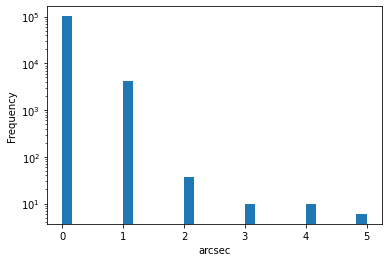

In [11]:
ax = ss.ssdistnr.plot.hist(bins=30, log=True)
ax.set_xlabel('arcsec')

Text(0.5, 0, 'Number of detections')

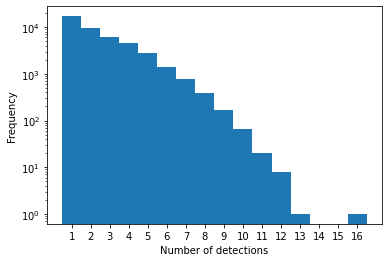

In [33]:
ndet = ss.groupby("ssnamenr").apply(lambda df: df.shape[0])
ax = ndet.plot.hist(log=True, bins=np.linspace(1,max(ndet)+1,max(ndet)+1)-.5)
ax.set_xticks(np.linspace(1,max(ndet),max(ndet)))
ax.set_xlabel('Number of detections')

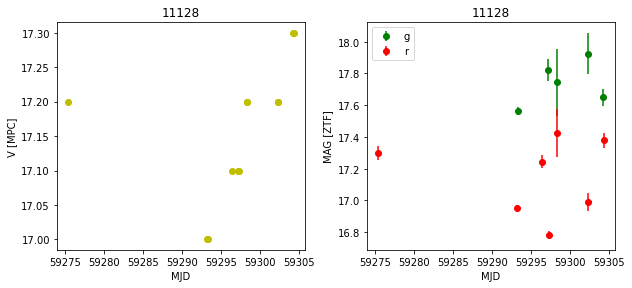

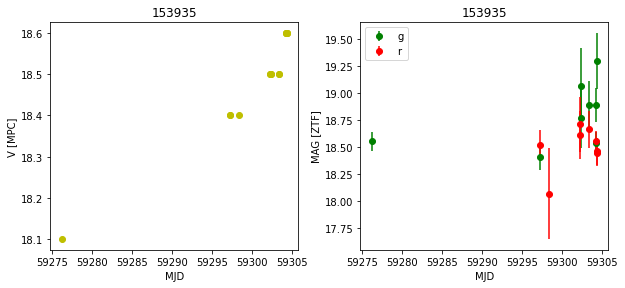

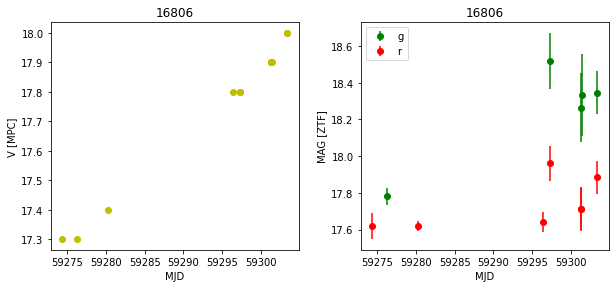

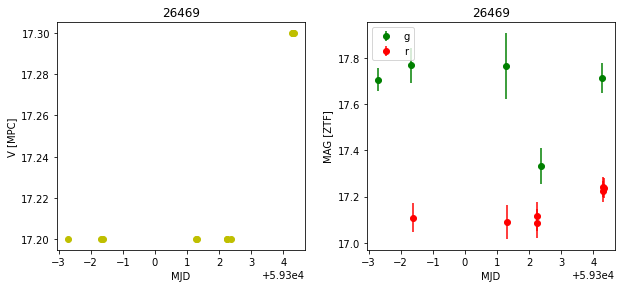

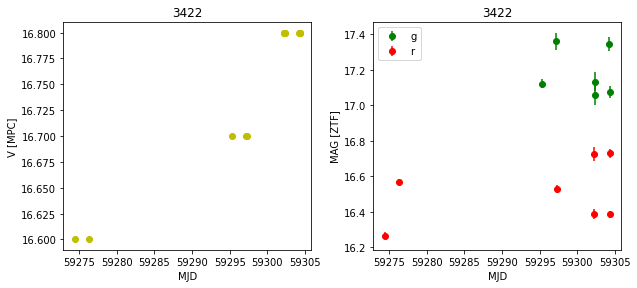

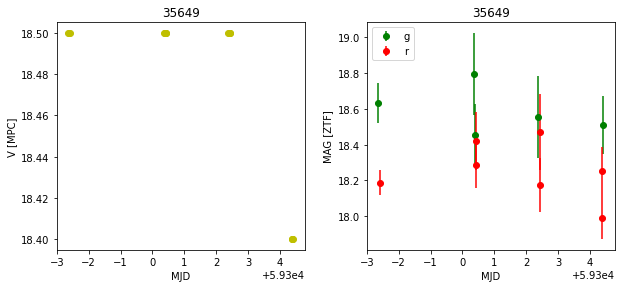

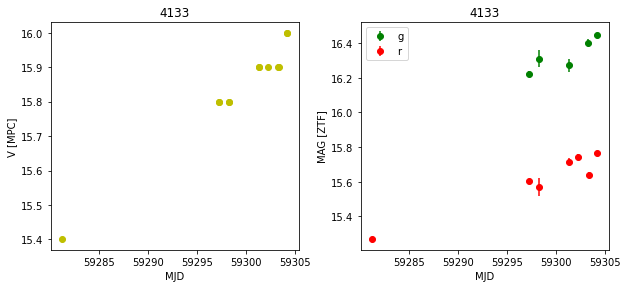

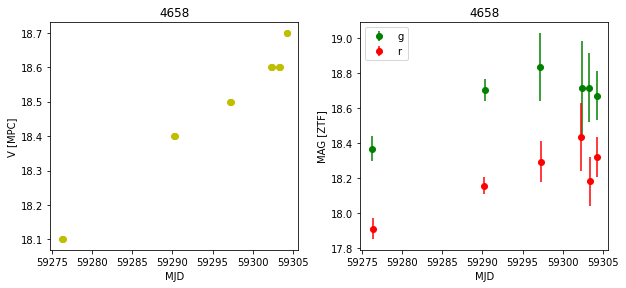

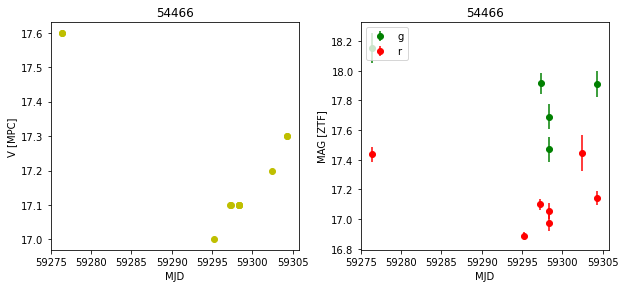

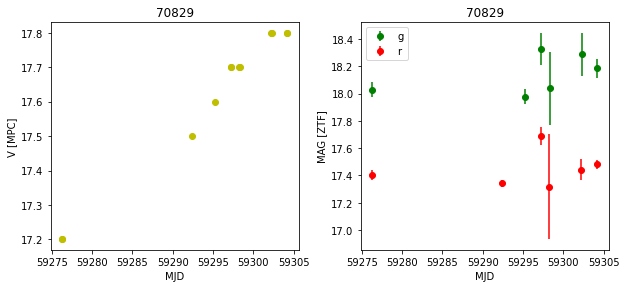

In [36]:
# Light curves predichas vs observadas en g y r

ndetmin = 12
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT oid, mjd, fid, magap, sigmagap, has_stamp
  FROM detection
  WHERE 
  oid in (%s)
  ORDER BY oid
  ''' % ",".join(["'%s'" % oid for oid in oids])

  dets = pd.read_sql_query(query, conn)
  Vmpc = ss.loc[ss.ssnamenr == ssnamenr].ssmagnr.values
  t = dets.mjd.values; mags = dets.magap.values; mags_err = dets.sigmagap.values
  filters = dets.fid.values; g = filters==1; r = filters==2
  fig, ax = plt.subplots(ncols=2, figsize=(10,4))
  fig.subplots_adjust(top=0.96, bottom=.17, hspace=0.05, wspace=0.25)

  ax[0].scatter(t, Vmpc, color='y')
  ax[0].set_title(ssnamenr); ax[0].set_xlabel("MJD"); ax[0].set_ylabel("V [MPC]")

  ax[1].errorbar(t[g], mags[g], yerr=mags_err[g], color='g', label='g', fmt='o')
  ax[1].errorbar(t[r], mags[r], yerr=mags_err[r], color='r', label='r', fmt='o')
  ax[1].set_title(ssnamenr); ax[1].set_xlabel("MJD"); ax[1].set_ylabel("MAG [ZTF]")
  ax[1].legend(loc="upper left")

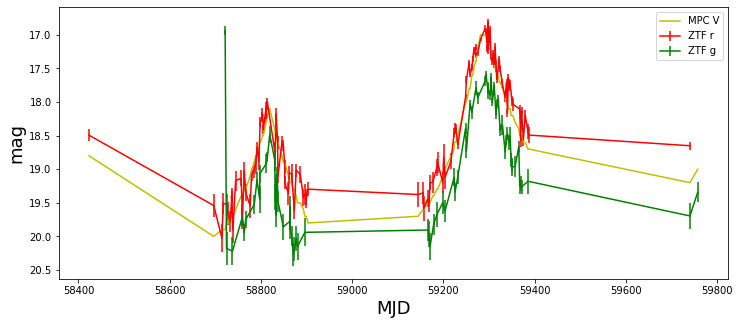

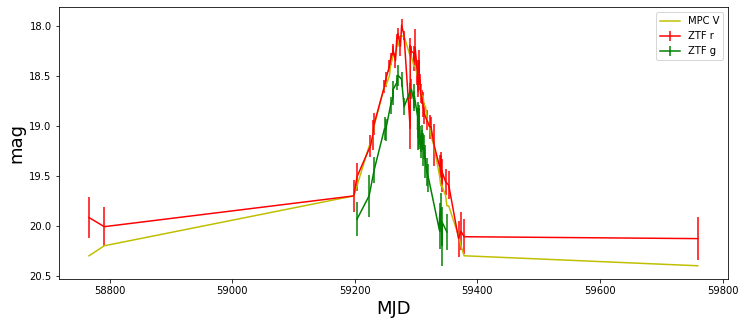

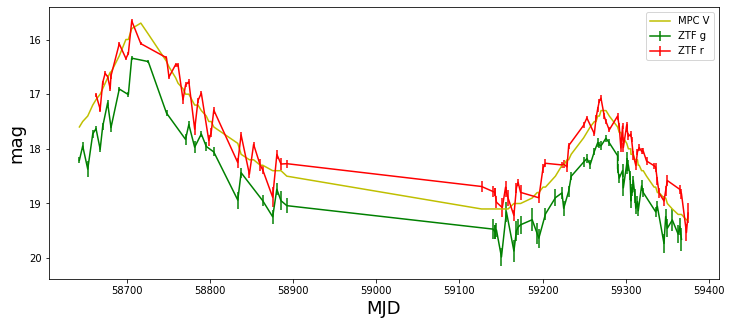

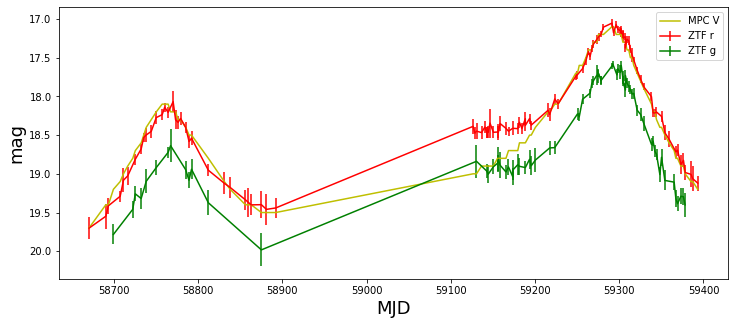

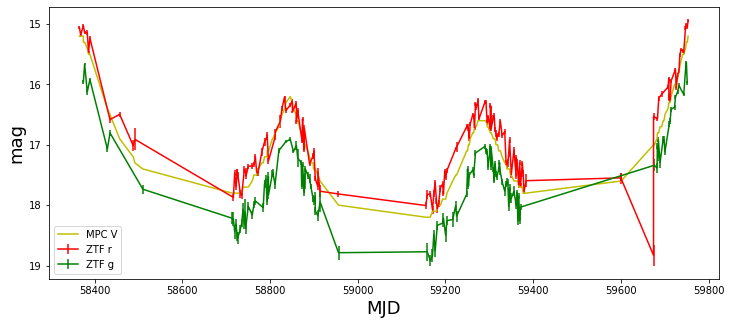

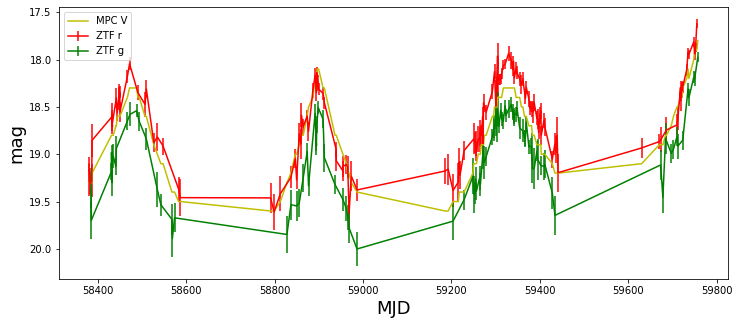

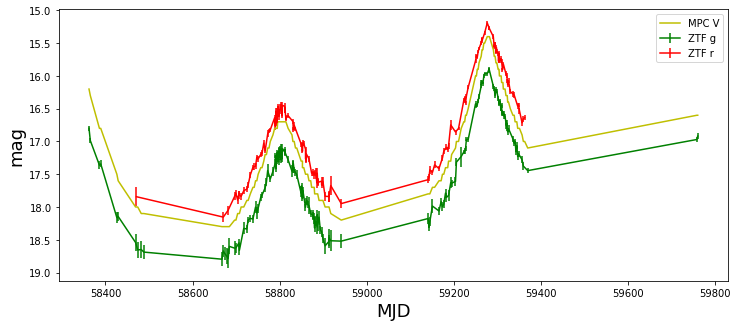

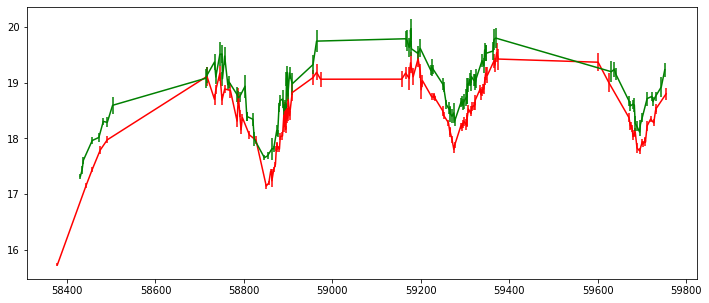

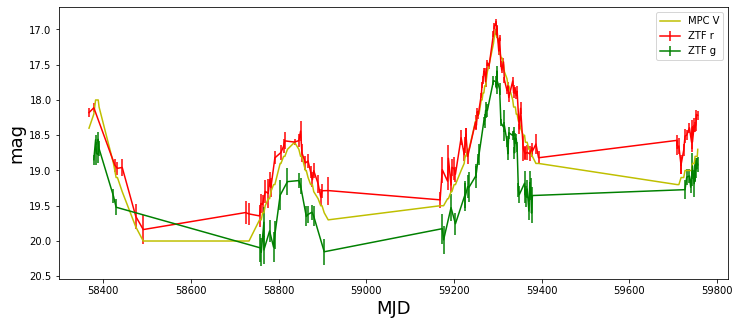

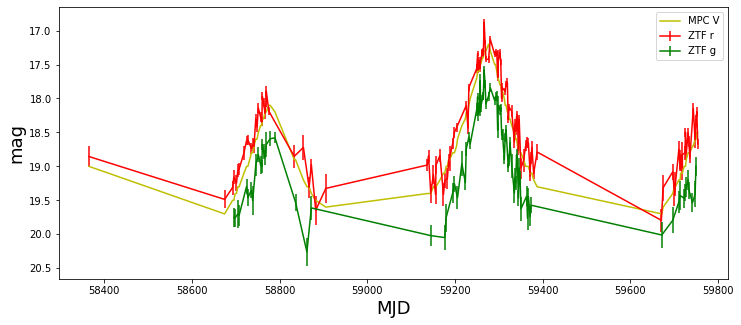

In [38]:
ndetmin = 12
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  colors = {1: 'g', 2: 'r'}
  fig, ax = plt.subplots(figsize=(12,5))
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)
    ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf, yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label = "ZTF %s" % colors[fid])
  if len(selast_lc.mjd) == len(selast.loc[selast_lc.index].ssmagnr):
    ax.plot(selast_lc.mjd, selast.loc[selast_lc.index].ssmagnr, c='y', label='MPC V')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("MJD", fontsize=18)
    ax.set_ylabel("mag", fontsize=18)
    ax.legend()

11128
153935
16806
26469
3422
35649
4133
54466
70829


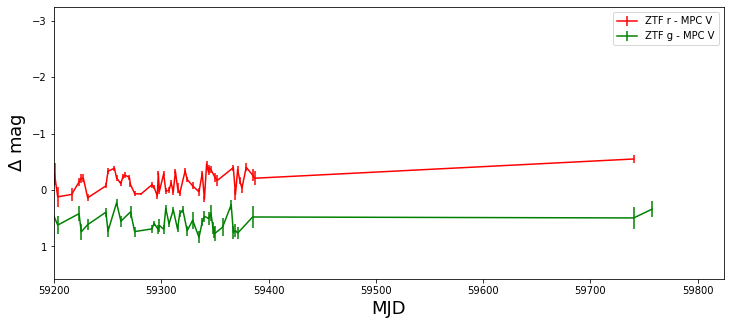

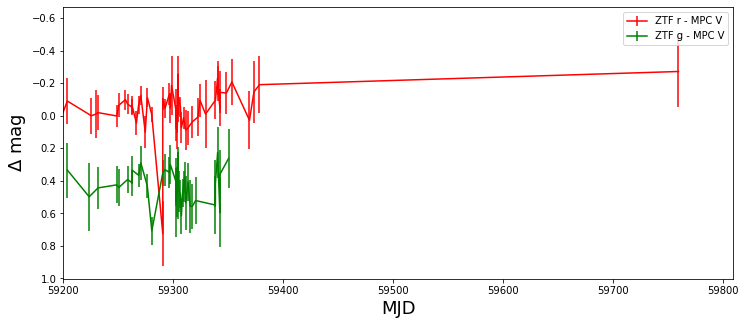

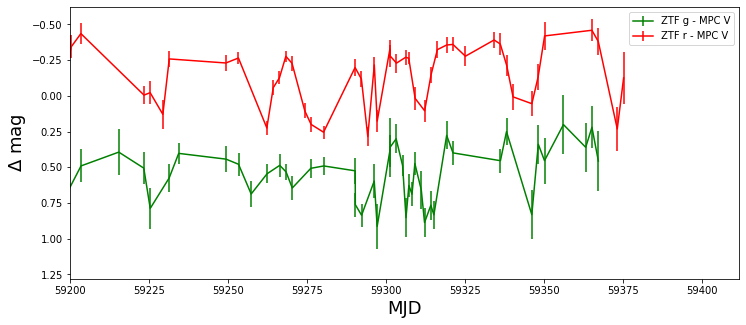

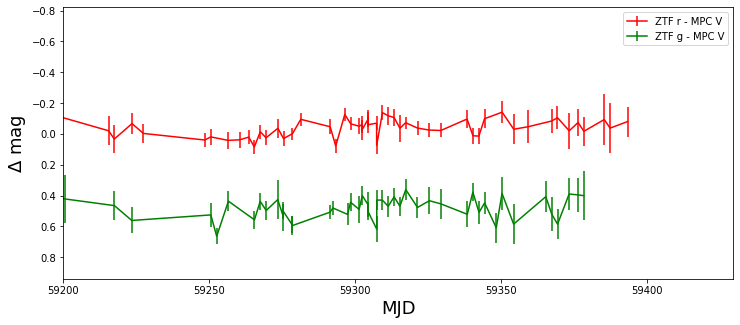

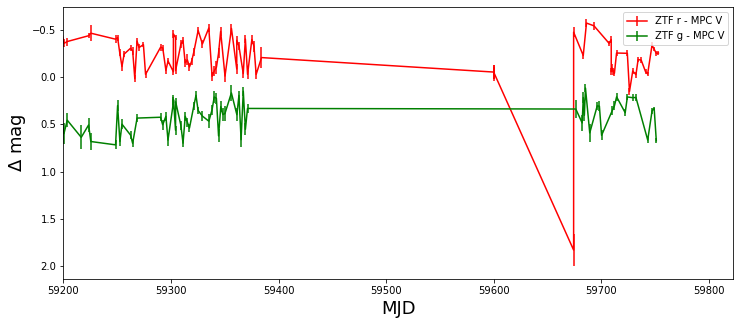

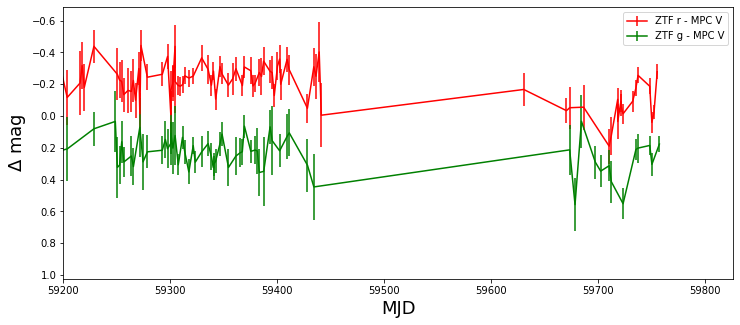

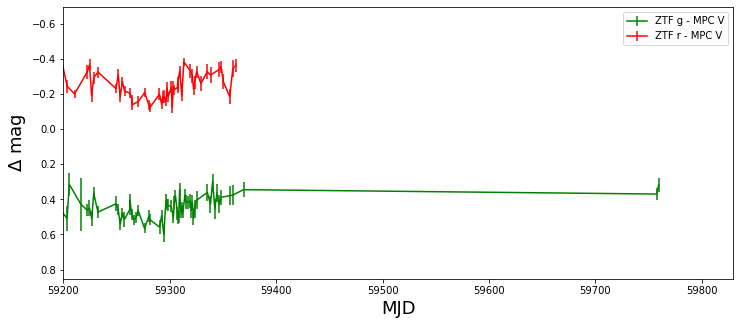

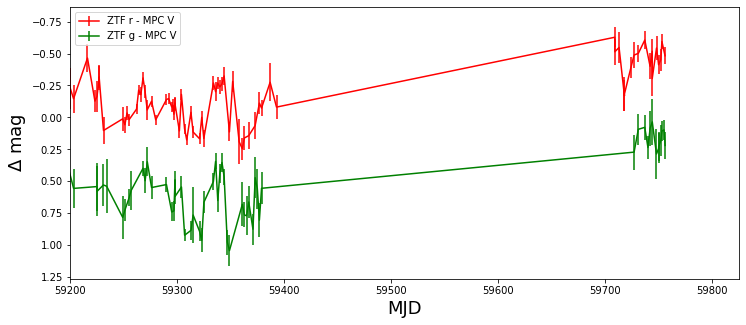

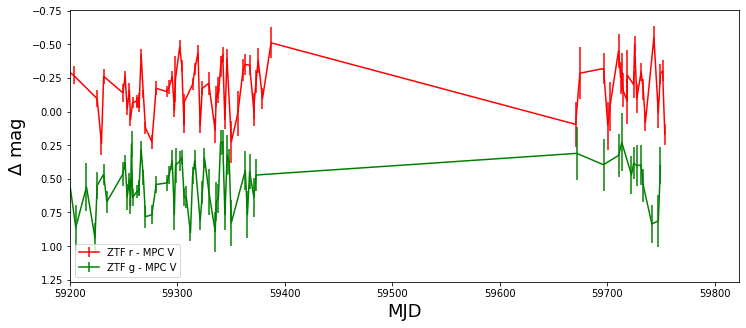

In [43]:
ndetmin = 12
ndet2 =ndet.drop(index= '4658')
for ssnamenr in ndet2.loc[ndet>=ndetmin].index:
  print(ssnamenr)
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  colors = {1: 'g', 2: 'r'}
  fig, ax = plt.subplots(figsize=(12,5))
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)
    ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf - selast.loc[selast_lc.loc[mask].index].ssmagnr,
                yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label='ZTF %s - MPC V' % colors[fid])
  if len(selast_lc.mjd) == len(selast.loc[selast_lc.index].ssmagnr):
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlim(59200,ax.get_xlim()[1])
    ax.legend()
    ax.set_xlabel("MJD", fontsize=18)
    ax.set_ylabel(r"$\Delta$ mag", fontsize=18)